# Run Summa model locally on Jupyter server

Structure for Unifying Multiple Modeling Alternative [(SUMMA)](https://ral.ucar.edu/projects/summa) is a hydrologic modeling approach that is built on a common set of conservation equations and a common numerical solver, which together constitute the structural core of the model. Different modeling approaches can then be implemented within the structural core, enabling a controlled and systematic analysis of alternative modeling options, and providing insight for future model development.

This notebook provides the option to allow users to run SUMMA model locally. Please refer to the other two SUMMA notebooks for running with High-Performance Computer (HPC) options.

# Notebook Outline
- [Retrieve Resources](#resources)
- [Unzip model instance package](#unzip)
- [Install SUMMA model](#install)
- [PySumma to configure model parameters](#build)
- [Run summa model locally](#submit)
- [Check model output](#check)
- [Plot time series result](#plot)
- [Cleanup](#cleanup)

<a id='resources'></a>
## Retrieve a Summa model instance resource from HydroShare

### [For more info on this resource](https://www.hydroshare.org/resource/1f3f310af8364d2aa3e6a9459152a21c/)

In [1]:
resource_id = '1f3f310af8364d2aa3e6a9459152a21c'
import json
import os
from hs_restclient import HydroShare, HydroShareAuthBasic
auth = HydroShareAuthBasic("cybergis", "demo")
hs = HydroShare(auth=auth)
base_dir = os.path.abspath('/home/jovyan/work')
download_dir = os.path.join(base_dir, 'Downloads')
!mkdir -p {download_dir}
hs.getResource(resource_id, destination=download_dir, unzip=True)

<a id='unzip'></a>
## Unzip model instance package

In [2]:
import os
#Unzip model file
model_folder_name = "SummaModel_ReynoldsAspenStand_StomatalResistance_sopron"
file_manger_rel_path = "settings/summa_fileManager_riparianAspenSimpleResistance.txt"
content_folder = os.path.join(download_dir ,"{}/{}/data/contents".format(resource_id, resource_id))
import tempfile
workspace_dir = os.path.join(base_dir, 'workspace')
!mkdir -p {workspace_dir}
unzip_dir = tempfile.mkdtemp(dir=workspace_dir)
!cd {content_folder} && unzip -o {model_folder_name}.zip -d {unzip_dir}
print("Unzipping Done")

Archive:  SummaModel_ReynoldsAspenStand_StomatalResistance_sopron.zip
   creating: /home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/
   creating: /home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/
   creating: /home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/
  inflating: /home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc  
  inflating: /home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson  
   creating: /home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/
  inflating: /home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFl

<a id='install'></a>
## "Install" SUMMA model on Jupyter server (fix broken path in summa file_manager)

In [3]:
model_source_folder_path = os.path.join(unzip_dir, model_folder_name)
!cd {model_source_folder_path} && chmod +x ./installTestCases_local.sh
!cd {model_source_folder_path} && ./installTestCases_local.sh

TestCases installed


<a id='build'></a>

## Use PySumma to configure model parameters

In [4]:
executable = "/usr/bin/summa.exe"
! {executable} --version

----------------------------------------------------------------------
     SUMMA - Structure for Unifying Multiple Modeling Alternatives    
                           Version: v2.0.0
               Build Time: Wed Dec 11 19:48:42 UTC 2019
                  Git Branch: sopron_2018-0-gf18270c
          Git Hash: f18270c2ce5f2b5004c2b3e1799bd0969612bb68
----------------------------------------------------------------------


In [5]:
from pysumma import Simulation

# path to the SUMMA filemanager file on Jupyter
file_manager = os.path.join(model_source_folder_path, file_manger_rel_path)

# Create pySUMMA Simulation Object
S = Simulation(executable, file_manager)

# Configure the model
S.decisions['simulStart'].value = "2006-07-01 00:00"
S.decisions['simulFinsh'].value = "2007-08-20 00:00"
S.decisions['stomResist'].value = 'BallBerry'
# Save configiuration to disk
S._write_configuration()
print(S)

Executable path: /usr/bin/summa.exe
Simulation status: Initialized
File manager configuration:
'SUMMA_FILE_MANAGER_V1.0'    ! filemanager_version
'/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/settings/'    ! settings_path
'/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/'    ! input_path
'/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/output/'    ! output_path
'summa_zDecisions_riparianAspenSimpleResistance.txt'    ! decisions_path
'meta/summa_zTimeMeta.txt'    ! meta_time
'meta/summa_zLocalAttributeMeta.txt'    ! meta_attr
'meta/summa_zCategoryMeta.txt'    ! meta_type
'meta/summa_zForceMeta.txt'    ! meta_force
'meta/summa_zLocalParamMeta.txt'    ! meta_localparam
'meta/Model_Output.txt'    ! output_control
'meta/summa_zLocalModelIndexMeta.txt'    ! meta_localindex
'meta/summa_zBasinParamMeta.txt'    ! meta_basinparam
'met

<a id='submit'></a>
## Run summa model locally

In [6]:
S.start(run_option="local")

# wait for results I/O 
import time
time.sleep(5)

In [7]:
summa_output = os.path.join(model_source_folder_path, 
                            "output",
                            "vegImpactsTranspire_output_pysumma_run_timestep.nc")
print(summa_output)

/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/output/vegImpactsTranspire_output_pysumma_run_timestep.nc


<a id='check'></a>
## Check model output  -- NetCDF file

In [8]:
import xarray as xr
output_info = xr.open_dataset(summa_output)
output_info

<xarray.Dataset>
Dimensions:                    (gru: 1, hru: 1, ifcSoil: 9, ifcToto: 14, midSoil: 8, midToto: 13, time: 9961)
Coordinates:
  * time                       (time) datetime64[ns] 2006-07-01 ... 2007-08-20
  * hru                        (hru) int32 1
Dimensions without coordinates: gru, ifcSoil, ifcToto, midSoil, midToto
Data variables:
    pptrate                    (time, hru) float64 ...
    airtemp                    (time, hru) float64 ...
    hruId                      (hru) int32 ...
    basin__SurfaceRunoff       (time, gru) float64 ...
    basin__ColumnOutflow       (time, gru) float64 ...
    basin__AquiferStorage      (time, gru) float64 ...
    basin__AquiferRecharge     (time, gru) float64 ...
    basin__AquiferBaseflow     (time, gru) float64 ...
    basin__AquiferTranspire    (time, gru) float64 ...
    averageInstantRunoff       (time, gru) float64 ...
    averageRoutedRunoff        (time, gru) float64 ...
    nSnow                      (time, hru) int32 ..

<a id='plot'></a>
## Plot time series for total evapotranspiration

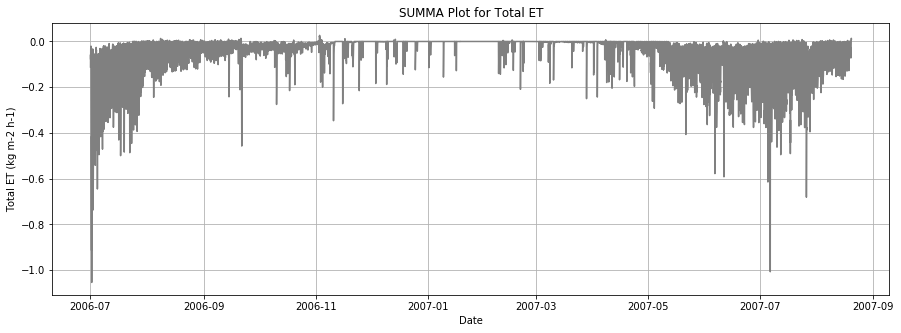

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
x = output_info['time']
y = (output_info['scalarCanopyTranspiration'] + \
     output_info['scalarCanopyEvaporation'] + \
     output_info['scalarGroundEvaporation'])*3600

plt.figure(figsize=(15, 5))
plt.plot(x, y, color='grey', linestyle='solid', markersize=0)

    # Get the current axis of the plot and
    # set the x and y-axis labels
ax = plt.gca()
ax.set_ylabel("Total ET (kg m-2 h-1)")
ax.set_xlabel('Date')
ax.grid(True)

ax.set_title('SUMMA Plot for Total ET')
output_info.close()

<a id='cleanup'></a>
## Cleanup

In [10]:
!rm -rvf {unzip_dir}

removed '/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc'
rm: cannot remove '/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData': Directory not empty
removed '/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson'
removed '/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFlux.nc'
removed directory '/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData'
removed '/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/installTestCases_local.sh'
removed '/home/jovyan/work/workspace/tmp1ehngo9s/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/output/runinfo.txt'
removed '/ho

## Done